# DataFrames and Spark SQL#

This lab will get you started with to higher-level abstractions: DataFrames and Spark SQL.

In [2]:
print sc

NameError: name 'sc' is not defined

## *The Martian* ##

Let's start by invoking a SQLContext and loading a dataset containing book reviews for Andy Weir's *The Martian*

In [3]:
sql_sc = SQLContext(sc)

df = sqlContext.read.csv(
    "./data/amazon_book_reviews/Andy-Weir-The-Martian.csv",
    sep="\t"
)

NameError: name 'sc' is not defined

How many reviews do we have?

In [4]:
df.count()

NameError: name 'df' is not defined

What are the column names and data types?

In [5]:
df.dtypes

NameError: name 'df' is not defined

Let's look at the top three rows in the dataset.

In [6]:
df.head(3)

NameError: name 'df' is not defined

Let's give the columns meaningful names. Since Spark DataFrames are built on top of RDDs and RDDs are immutable, we have to create a new data set.

In [7]:
df2 = df \
    .toDF(*["score", "url", "title", "review"])

How's that look?

In [8]:
df2.head()

Row(score=u'4.0', url=u'/gp/customer-reviews/RKMO449VT48H3?ASIN=1491590173', title=u'4.7573214851 Stars', review=u'"<span class=""a-size-base review-text"">I\'m a hard-science science fiction fan and would rather read hard sc-fi than almost anything. I love stories and movies about Mars, and I\'m a fan of survival, castaway, and man-against-the elements stories. I loved Robinson Crusoe, so it should not surprise you that I loved the movie, Robinson Crusoe on Mars. I realize it\'s not Academy Award material, but to me, it\'s everything I want it to be, as was this book, The Martian.<br/><br/>The main character, Watney, presumed dead, is accidentally left by his crew mates when an intense Martian dust storm forces them to abort their mission. What follows for part of the book is a logbook style narrative that describes in great technical detail Watney\'s efforts to extend his life until the next scheduled mission arrives in 4 years. After reading just the first 20% of the book (my Kindle

## Scores ##

Better. Let's use some SQL-like function to inspect `scores`. These are the star ratings that people gave to The Martian in their reviews.

In [9]:
df2.select("score").show()

+-----+
|score|
+-----+
|  4.0|
|  3.0|
|  4.0|
|  5.0|
|  5.0|
|  5.0|
|  3.0|
|  3.0|
|  5.0|
|  5.0|
|  4.0|
|  3.0|
|  2.0|
|  5.0|
|  3.0|
|  2.0|
|  3.0|
|  5.0|
|  3.0|
|  3.0|
+-----+
only showing top 20 rows



How common is each rating? We can use more SQL-like syntax to inspect.

In [10]:
_result = (df2
    .groupBy("score")
    .count()
    .orderBy("score")
)

_result.show()

+-----+-----+
|score|count|
+-----+-----+
|  1.0|  236|
|  2.0|  286|
|  3.0| 3010|
|  4.0| 5626|
|  5.0|13413|
+-----+-----+



In [11]:
_result_df = _result.toPandas()
_result_df

,score,count
0,1.0,236
1,2.0,286
2,3.0,3010
3,4.0,5626
4,5.0,13413


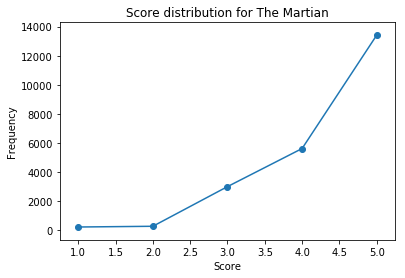

In [12]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.plot(_result_df.score, _result_df['count'])
plt.scatter(list(_result_df['score']), _result_df['count'])
plt.title("Score distribution for The Martian")
plt.xlabel("Score")
plt.ylabel("Frequency")

Mostly 5's. Not bad!

Note that these "scores" are still stored as strings until we dump them to pandas. Let's convert them to integers, so that we can use them for ML.

To do that, we need to 
1. Create a conversion function
2. Wrap it in a sparkSQL udf
3. Apply it to the old, string-based column
4. Capture the result in a new dataframe (because the old one is immutable)

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

#Create the conversion function
def convert_to_int(x):
    return int(float(x))

assert convert_to_int("1.0") == 1

#Wrap it as a sparkSQL udf
convert_to_int_udf = udf(convert_to_int, IntegerType())

df3 = df2 \
    .withColumn("score_int", convert_to_int_udf(df2.score))

Let's verify that it worked by calculating the average score.

In [14]:
df3.agg({
    'score_int' : 'avg',
}).collect()

[Row(avg(score_int)=4.4041912188206105)]

...and just for fun, let's get some other stats, too.

In [15]:
print df3.agg({
    'score_int' : 'stddev',
}).collect()

print df3.agg({
    'score_int' : 'min',
}).collect()

print df3.agg({
    'score_int' : 'max',
}).collect()

[Row(stddev(score_int)=0.8420590917433144)]
[Row(min(score_int)=1)]
[Row(max(score_int)=5)]


## Sentiment modeling ##

Let's gear up now to build our first predictive model. To get there, we're going to need to extract some features from that text.

We'll start by loading [wordlists](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon) for positive and negative sentiment. To speed up some later steps, we're going to load them as sets.

In [16]:
pos_word_set = set(file("./data/positive_word_list.txt").read().splitlines())
neg_word_set = set(file("./data/negative_word_list.txt").read().splitlines())

print list(pos_word_set)[:10]
print list(neg_word_set)[:10]

['unencumbered', 'pardon', 'saver', 'desirable', 'encouragingly', 'sleek', 'pamperedly', 'worked', 'undisputed', 'sagely']
['limited', 'subtract', 'suicidal', 'cussed', 'interference', 'dissolution', 'refutes', 'threatening', 'foul', 'obstruction']


Now we need to convert the raw text of the Martian reviews into positive and negative sentiment scores.

First we define our UDFs.

In [17]:
import re

get_len_udf = udf(len, IntegerType())

def positive_sentiment_score(x):
    token_set = set(re.findall('\w+', x.lower()))
    return len(pos_word_set.intersection(token_set))

assert positive_sentiment_score("The saver is sleek and desirable and worked.") == 4

positive_sentiment_score_udf = udf(positive_sentiment_score, IntegerType())

def negative_sentiment_score(x):
    token_set = set(re.findall('\w+', x.lower()))
    return len(neg_word_set.intersection(token_set))

negative_sentiment_score_udf = udf(negative_sentiment_score, IntegerType())

assert negative_sentiment_score("It's a cussed limited intereference threatening to subtract.") == 4

Now let's apply all those functions. We're just going to re-create df3.

In [1]:
df3 = df2 \
    .withColumn("score_int", convert_to_int_udf(df2.score)) \
    .withColumn("review_len", get_len_udf(df2.review)) \
    .withColumn("positive_sentiment", positive_sentiment_score_udf(df2.review)) \
    .withColumn("negative_sentiment", negative_sentiment_score_udf(df2.review))

NameError: name 'df2' is not defined

Grab a sample of the data... (Do these look correlated to you?)

In [19]:
df3.select(['score_int', 'review_len', 'positive_sentiment', 'negative_sentiment']).show()

+---------+----------+------------------+------------------+
|score_int|review_len|positive_sentiment|negative_sentiment|
+---------+----------+------------------+------------------+
|        4|      3298|                18|                19|
|        3|      2066|                10|                12|
|        4|      2246|                12|                13|
|        5|       573|                 4|                 3|
|        5|      1081|                12|                 6|
|        5|      2407|                22|                17|
|        3|       845|                 7|                 6|
|        3|       316|                 3|                 1|
|        5|       324|                 4|                 2|
|        5|       582|                 3|                 0|
|        4|      5087|                28|                30|
|        3|      2337|                14|                13|
|        2|      4662|                32|                20|
|        5|      2564|  

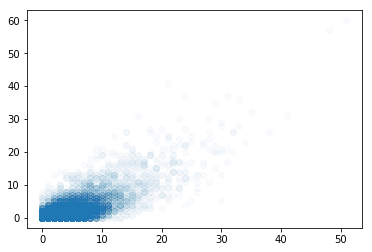

In [20]:
df3_pandas = df3.toPandas()
plt.scatter(df3_pandas.positive_sentiment, df3_pandas.negative_sentiment, alpha=.025)

How are positive sentiment scores distributed?

In [21]:
(
    df3
        .groupby('positive_sentiment')
        .count()
        .sort('positive_sentiment')
        .show()
)

+------------------+-----+
|positive_sentiment|count|
+------------------+-----+
|                 0| 1202|
|                 1| 5307|
|                 2| 4535|
|                 3| 3735|
|                 4| 2607|
|                 5| 1674|
|                 6| 1021|
|                 7|  694|
|                 8|  473|
|                 9|  341|
|                10|  232|
|                11|  168|
|                12|  107|
|                13|   90|
|                14|   69|
|                15|   60|
|                16|   40|
|                17|   42|
|                18|   29|
|                19|   22|
+------------------+-----+
only showing top 20 rows



And negative...?

In [22]:
(
    df3
        .groupby('negative_sentiment')
        .count()
        .sort('negative_sentiment')
        .show()
)

+------------------+-----+
|negative_sentiment|count|
+------------------+-----+
|                 0|10754|
|                 1| 5598|
|                 2| 2644|
|                 3| 1304|
|                 4|  730|
|                 5|  414|
|                 6|  259|
|                 7|  199|
|                 8|  138|
|                 9|  104|
|                10|   66|
|                11|   65|
|                12|   56|
|                13|   43|
|                14|   35|
|                15|   17|
|                16|   24|
|                17|   26|
|                18|   11|
|                19|   19|
+------------------+-----+
only showing top 20 rows



Let's use SQL syntax to look for general patterns in sentiment.

To do that, we first register `df3` as a table in spark.sql. Then we can use SQL syntax to inspect it.

There are many ways we could slice the data. One good one is to look at net positivity per thousand words. This balances positive and negative sentiment, and also controls for the length of reviews.

In [23]:
df3.createOrReplaceTempView("df3")

_result = spark.sql("""
SELECT
    score,
    COUNT(*),
    AVG(1000*(positive_sentiment - negative_sentiment)/review_len) AS net_positivity_per_1000words,
    STDDEV(1000*(positive_sentiment - negative_sentiment)/review_len) / SQRT(COUNT(*)) AS stderr
FROM df3
GROUP BY score
ORDER BY score
""")
_result.show()

+-----+--------+----------------------------+-------------------+
|score|count(1)|net_positivity_per_1000words|             stderr|
+-----+--------+----------------------------+-------------------+
|  1.0|     236|          1.4227200501472765| 0.6087601559657656|
|  2.0|     286|           6.542463274800939| 0.4885662136721518|
|  3.0|    3010|            8.81046970667028|0.15367325748251096|
|  4.0|    5626|           8.985647815047667| 0.1127071877576759|
|  5.0|   13413|           9.320046770446156|0.07299042337041249|
+-----+--------+----------------------------+-------------------+



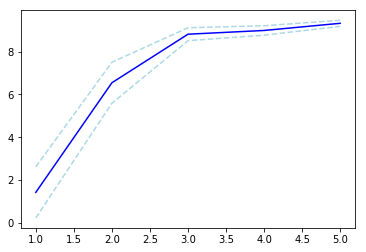

In [24]:
_result_df = _result.toPandas()
plt.plot(_result_df.score, _result_df.net_positivity_per_1000words, c='blue')
plt.plot(_result_df.score, _result_df.net_positivity_per_1000words+_result_df.stderr*1.96, c='lightblue', linestyle='--')
plt.plot(_result_df.score, _result_df.net_positivity_per_1000words-_result_df.stderr*1.96, c='lightblue', linestyle='--')

This looks pretty good. Net positivity increases strongly with improved ratings. At least some of these differences are statistically significant.

## Exercise 1 : DataFrame essentials ##

Load the data for a different book review: `"./data/amazon_book_reviews/Suzanne-Collins-The-Hunger-Games.csv"`

- How many rows does it have?
- What are the data types?
- What do the first 5 rows look like?

Just like we did above, let's...
- Add column names
- Use a UDF to clean up the data type for score
- Use a UDF and add columns for positive and negative sentiment

Last, write new UDFs and add columns for
- `review_char_length`: the number of characters in the review
- `review_word_length`: the number of words in the review

In [25]:
hunger_games_df = sqlContext.read.csv(
    "./data/amazon_book_reviews/Suzanne-Collins-The-Hunger-Games.csv",
    sep="\t"
)

## Exercise 2 : Convenient abstraction ##

Create a function that accepts a filename as an argument, does everything we did in Exercise 1, and returns the resulting Spark DataFrame.

In [34]:
def load_and_clean_book_review_df(filename):
    review_df = sqlContext.read.csv(filename, sep="\t")
    
    
    return review_df

## Exercise 3 : Aggregation queries ##

There are 8 books in `data/amazon_book_reviews/`:
```
    Andy-Weir-The-Martian.csv
    Donna-Tartt-The-Goldfinch.csv
    Suzanne-Collins-The-Hunger-Games.csv
    Laura-Hillenbrand-Unbroken.csv
    EL-James-Fifty-Shades-of-Grey.csv
    John-Green-The-Fault-in-our-Stars.csv
    Paula_Hawkins-The-Girl-On-The-Train.csv
    Fillian_Flynn-Gone_Girl.csv
```
Pick a new book review and load it using your function.

- Use `select` to show the first five rows
- Use `agg` to calculate the mean, stddev, min, and max scores for 
- What is the average positivity score?
- ...Negativity score?
- ...Net positivity per 1000 words?

In [35]:
sql_sc = SQLContext(sc)

df = sqlContext.read.csv(
    "./data/amazon_book_reviews/Donna-Tartt-The-Goldfinch.csv",
    sep="\t"
)

df.createOrReplaceTempView("dftemp")

_result = spark.sql("""
SELECT *
FROM dftemp
LIMIT 10
""")

'''
df3 = df2 \
    .withColumn("score_temp", df2.score)
'''    
df = df \
    .toDF(*["score", "url", "title", "review"])    
    
df.agg({
    'score' : 'avg',
}).collect()


print df.agg({
    'score' : 'stddev',
}).collect()

print df.agg({
    'score' : 'min',
}).collect()

print df.agg({
    'score' : 'max',
}).collect()


df2 = df \
.withColumn("score", convert_to_int_udf(df.score)) \
    .withColumn("review_len", get_len_udf(df.review)) \
 .withColumn("positive_sentiment", positive_sentiment_score_udf(df.review)) \
    .withColumn("negative_sentiment", negative_sentiment_score_udf(df.review))
    
    
df2.createOrReplaceTempView("dftemp")

print df2.dtypes

_result = spark.sql("""
SELECT
    score,
    AVG(1000*(positive_sentiment - negative_sentiment)/review_len) AS net_positivity_per_1000words
   
FROM dftemp
GROUP BY score
ORDER BY score
""")
_result.show()
    
print df2.agg({
    'positive_sentiment' : 'avg',
}).collect()


print df2.agg({
    'negative_sentiment' : 'avg',
}).collect()




[Row(stddev(score)=1.2884680069300456)]
[Row(min(score)=u'1.0')]
[Row(max(score)=u'5.0')]
[('score', 'int'), ('url', 'string'), ('title', 'string'), ('review', 'string'), ('review_len', 'int'), ('positive_sentiment', 'int'), ('negative_sentiment', 'int')]
+-----+----------------------------+
|score|net_positivity_per_1000words|
+-----+----------------------------+
|    1|           2.565283513027294|
|    2|           3.550833891956671|
|    3|           4.299278057024462|
|    4|           4.845162697865055|
|    5|           4.903044411473793|
+-----+----------------------------+

[Row(avg(positive_sentiment)=2.8309785223743495)]
[Row(avg(negative_sentiment)=1.8818074449936573)]


## Exercise 5 : Lather, rinse, repeat ##

Try some of the other books in the Amazon book reviews dataset.

- Which book has the highest average score?
- ...the highest proportion of negative reviews? (Score = 1 or 2)
- ...the highest net positivity per 1000 words?
- ...the highest net positivity per 1000 words among favorable reviews?
- ...the highest net positivity per 1000 words among unfavorable reviews?

Based on the answers to these questions, can you say anything about which books were the most polarizing?

- Add additional analysis if you need to.
- Last, generate the two or three graphs that will tell your polarization story most clearly.

In [ ]:
import re

sql_sc = SQLContext(sc)

books = ['Andy-Weir-The-Martian.csv',
    'Donna-Tartt-The-Goldfinch.csv',
    'Suzanne-Collins-The-Hunger-Games.csv',
    'Laura-Hillenbrand-Unbroken.csv',
    'EL-James-Fifty-Shades-of-Grey.csv',
    'John-Green-The-Fault-in-our-Stars.csv',
    'Paula_Hawkins-The-Girl-On-The-Train.csv',
    'Fillian_Flynn-Gone_Girl.csv',
]

df2  = []
avg_scores = []

final_dict = {}
negative_dict2 = {}

highest_net_positivity  = {}

highest_net_positivity_fav = {}


highest_net_neg_fav = {}

for i in range(len(books)):

    df = load_and_clean_book_review_df("./data/amazon_book_reviews/"+books[i])
    df = df \
    .toDF(*["score", "url", "title", "review"])
    
    df2 = df \
    .withColumn("score", convert_to_int_udf(df.score)) \
    .withColumn("review_len", get_len_udf(df.review)) \
    .withColumn("positive_sentiment", positive_sentiment_score_udf(df.review)) \
    .withColumn("negative_sentiment", negative_sentiment_score_udf(df.review))
    
    neg_reviews = df2.agg({
    'negative_sentiment' : 'max',
    }).head()
    
    avg_scores = df.agg({
    'score' : 'avg',
    }).head()
    
    
    #print(avg_scores.count)
    avg_scores_num = avg_scores[0]
    
    final_dict[books[i]] = avg_scores_num
    
    negative_dict2[books[i]] = neg_reviews[0]
    
    df2.createOrReplaceTempView("dftemp")

    #print df2.dtypes

    _result = spark.sql("""
    SELECT       
        AVG(1000*(positive_sentiment - negative_sentiment)/review_len) AS net_positivity_per_1000words
    FROM dftemp
   
    """)
    
    highest_net_positivity[books[i]] =  _result.head()[0]
    
    df2.createOrReplaceTempView("dftemp2")

    _result = spark.sql("""
    SELECT max(net_positivity_per_1000words) FROM (
    SELECT       
        positive_sentiment,
        AVG(1000*(positive_sentiment - negative_sentiment)/review_len) AS net_positivity_per_1000words       
    FROM dftemp2
    GROUP BY positive_sentiment)
    
    """)
    
    highest_net_positivity_fav[books[i]] =  _result.head()[0]
    
    df2.createOrReplaceTempView("dftemp2")

    _result = spark.sql("""
    SELECT max(net_positivity_per_1000words) FROM (
    SELECT       
        negative_sentiment,
        AVG(1000*(positive_sentiment - negative_sentiment)/review_len) AS net_positivity_per_1000words       
    FROM dftemp2
    GROUP BY negative_sentiment)
    
    """)
    
    highest_net_neg_fav[books[i]] =  _result.head()[0]
    
    
    
    
   
    

key, value = max(final_dict.iteritems(), key=lambda x:x[1])
print(key,value)
#print(final_dict)
    
    
key, value = max(negative_dict2.iteritems(), key=lambda x:x[1])
print(key,value)
#print(negative_dict2)
    
    
key, value = max(highest_net_positivity.iteritems(), key=lambda x:x[1])
print(key,value)

    

key, value = max(highest_net_positivity_fav.iteritems(), key=lambda x:x[1])
print(key,value)


key, value = max(highest_net_neg_fav.iteritems(), key=lambda x:x[1])
print(key,value)




